In [14]:
# Imports for Dataset class
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms

# Imports for dataloader
from torch.utils.data import DataLoader

# Imports for CNN
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

# Imports for plotting/evaluation
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from sklearn.metrics import classification_report
import pandas as pd

In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [3]:
class ASLDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (str): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                                            on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.label_mapping = {}  # Mapping from original labels to continuous range

        # Collect all image paths and labels
        for filename in os.listdir(root_dir):
            if filename.startswith('color_'):
                # Extract label from filename
                parts = filename.split('_')
                label = int(parts[1])  # Assuming the label is the second part of the filename
                self.image_paths.append(os.path.join(root_dir, filename))
                self.labels.append(label)

        # Create a continuous label mapping
        unique_labels = sorted(set(self.labels))
        self.label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
        self.labels = [self.label_mapping[label] for label in self.labels]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')  # Ensure image is in grayscale
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


root_dir = 'dataset5_50x50_split/'
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1] range for grayscale
])

# Create dataset instances
train_dataset = ASLDataset(root_dir=os.path.join(root_dir, 'train'), transform=transform)
val_dataset = ASLDataset(root_dir=os.path.join(root_dir, 'val'), transform=transform)
test_dataset = ASLDataset(root_dir=os.path.join(root_dir, 'test'), transform=transform)


In [4]:
# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
# Class for CNN following paper 1 architecture
class PaperCNN(nn.Module):
    def __init__(self, num_classes=24):
        super(PaperCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout2d(0.3)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.dropout2 = nn.Dropout2d(0.3)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(128, 512, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(512)
        self.dropout3 = nn.Dropout2d(0.3)
        
        self.conv4 = nn.Conv2d(512, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.dropout4 = nn.Dropout2d(0.3)
        
        self.conv5 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(32)
        self.dropout5 = nn.Dropout2d(0.3)
        
        self.fc1 = nn.Linear(32 * 3 * 3, 512)
        self.dropout_fc1 = nn.Dropout(0.3)
        
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        # convrelu - dropout - bn
        x = self.bn1(self.dropout1(F.relu(self.conv1(x))))
#         print(f"Shape after conv1 + relu + dropout + bn1: {x.shape}")
        
        x = self.bn2(self.dropout2(F.relu(self.conv2(x))))
#         print(f"Shape after conv2 + relu + dropout + bn2: {x.shape}")
        x = self.pool(x)
#         print(f"Shape after pool: {x.shape}")
        
        x = self.bn3(self.dropout3(F.relu(self.conv3(x))))
#         print(f"Shape after conv3 + relu + dropout + bn3: {x.shape}")
        x = self.pool(x)
#         print(f"Shape after pool: {x.shape}")
        
        x = self.bn4(self.dropout4(F.relu(self.conv4(x))))
#         print(f"Shape after conv4 + relu + dropout + bn4: {x.shape}")
        x = self.pool(x)
#         print(f"Shape after pool: {x.shape}")
        
        x = self.bn5(self.dropout5(F.relu(self.conv5(x))))
#         print(f"Shape after conv5 + relu + dropout + bn4: {x.shape}")
        x = self.pool(x)
#         print(f"Shape after pool: {x.shape}")
        
        x = x.view(-1, 32 * 3 * 3)  # Flatten the output of the last conv layer
#         print(f"Shape after view: {x.shape}")
        
        x = self.dropout_fc1(F.relu(self.fc1(x)))
        x = self.fc2(x)
        
        return x

In [6]:
# Function to infer number of classes
def get_num_classes(dataset):
    """
    Get the number of unique classes in the dataset.

    Args:
        dataset (Dataset): The dataset to analyze.

    Returns:
        int: The number of unique classes.
    """
    unique_labels = set()
    for _, label in dataset:
        unique_labels.add(label)
    return len(unique_labels)

In [7]:
# Initialize the model, loss function, and optimizer
num_classes = get_num_classes(train_dataset)
model = PaperCNN(num_classes=num_classes)
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
model.to(device)
print("Model initialized")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
print("Optimizer initialized")

# Initialize lists to track metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


# Training loop with tqdm progress bar
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
    for images, labels in train_loader_tqdm:
        # move images and labels to device
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        train_loader_tqdm.set_postfix(loss=running_loss/len(train_loader))
        
        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)
    
    print(f"Epoch {epoch+1}, Loss: {epoch_loss}, Accuracy: {train_accuracy}%")

    # Validation loop
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in val_loader:
            # move images and labels to device
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0tva)
            correct_val += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    epoch_val_loss = running_val_loss / len(val_loader)
    val_losses.append(epoch_val_loss)
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {epoch_val_loss}, Validation Accuracy: {val_accuracy}%")


print("Training complete")

Model initialized
Optimizer initialized


Epoch 1/10: 100%|████████████| 1439/1439 [05:09<00:00,  4.65batch/s, loss=0.965]


Epoch 1, Loss: 0.9646923174101748, Accuracy: 69.05366955539628%
Validation Loss: 0.21971037769901136, Validation Accuracy: 92.79343198864788%


Epoch 2/10: 100%|████████████| 1439/1439 [04:57<00:00,  4.84batch/s, loss=0.339]


Epoch 2, Loss: 0.33935241674055566, Accuracy: 88.92074455376729%
Validation Loss: 0.09348685403044026, Validation Accuracy: 96.91871072369754%


Epoch 3/10: 100%|████████████| 1439/1439 [05:09<00:00,  4.66batch/s, loss=0.235]


Epoch 3, Loss: 0.23532694360517, Accuracy: 92.38722008644469%
Validation Loss: 0.05920053039101769, Validation Accuracy: 98.12487330225015%


Epoch 4/10: 100%|████████████| 1439/1439 [04:54<00:00,  4.89batch/s, loss=0.187]


Epoch 4, Loss: 0.18744036452126345, Accuracy: 93.86199257183814%
Validation Loss: 0.04863639734205066, Validation Accuracy: 98.52017028177579%


Epoch 5/10: 100%|████████████| 1439/1439 [04:52<00:00,  4.93batch/s, loss=0.155]


Epoch 5, Loss: 0.15547787993395593, Accuracy: 94.88064985556352%
Validation Loss: 0.0375421382972355, Validation Accuracy: 98.8749239813501%


Epoch 6/10: 100%|████████████| 1439/1439 [04:42<00:00,  5.09batch/s, loss=0.139]


Epoch 6, Loss: 0.13888335924718886, Accuracy: 95.52138311504963%
Validation Loss: 0.03138641191412496, Validation Accuracy: 99.10804784107034%


Epoch 7/10: 100%|████████████| 1439/1439 [04:48<00:00,  4.98batch/s, loss=0.128]


Epoch 7, Loss: 0.12814464589250496, Accuracy: 95.81460003040768%
Validation Loss: 0.027428502034612376, Validation Accuracy: 99.22967768092438%


Epoch 8/10: 100%|████████████| 1439/1439 [04:48<00:00,  4.99batch/s, loss=0.116]


Epoch 8, Loss: 0.11571830528947803, Accuracy: 96.28374709498055%
Validation Loss: 0.02302920275742567, Validation Accuracy: 99.30062842083925%


Epoch 9/10: 100%|████████████| 1439/1439 [04:54<00:00,  4.89batch/s, loss=0.106]


Epoch 9, Loss: 0.10597593140435005, Accuracy: 96.55524423883061%
Validation Loss: 0.020634334192742763, Validation Accuracy: 99.36144334076627%


Epoch 10/10: 100%|██████████| 1439/1439 [04:45<00:00,  5.04batch/s, loss=0.0981]


Epoch 10, Loss: 0.09814954308655095, Accuracy: 96.83108533698226%
Validation Loss: 0.020137036704800503, Validation Accuracy: 99.3411717007906%
Training complete


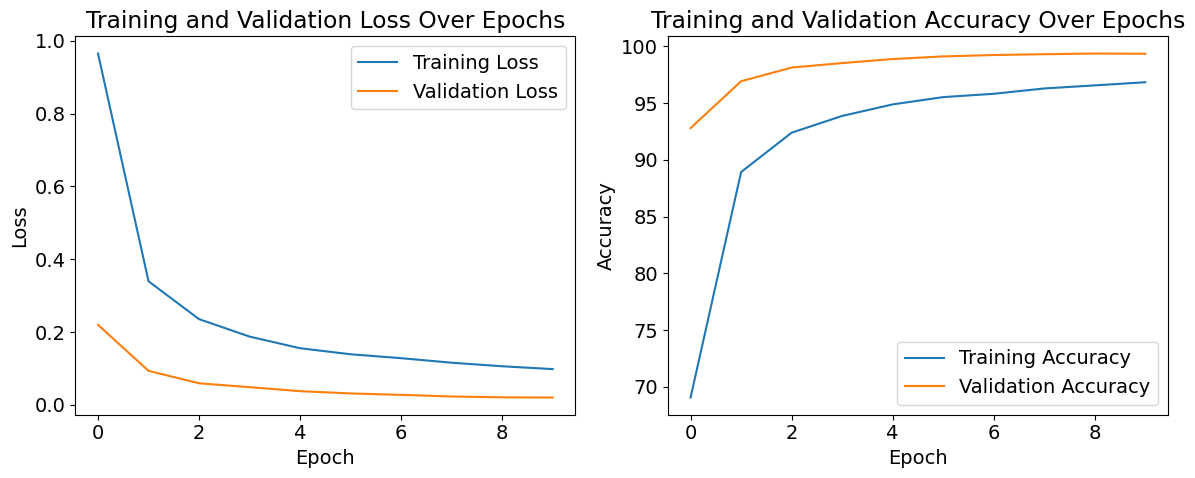

In [16]:
import matplotlib.pyplot as plt

# Set the default font size
plt.rcParams.update({'font.size': 14})

# Plot training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


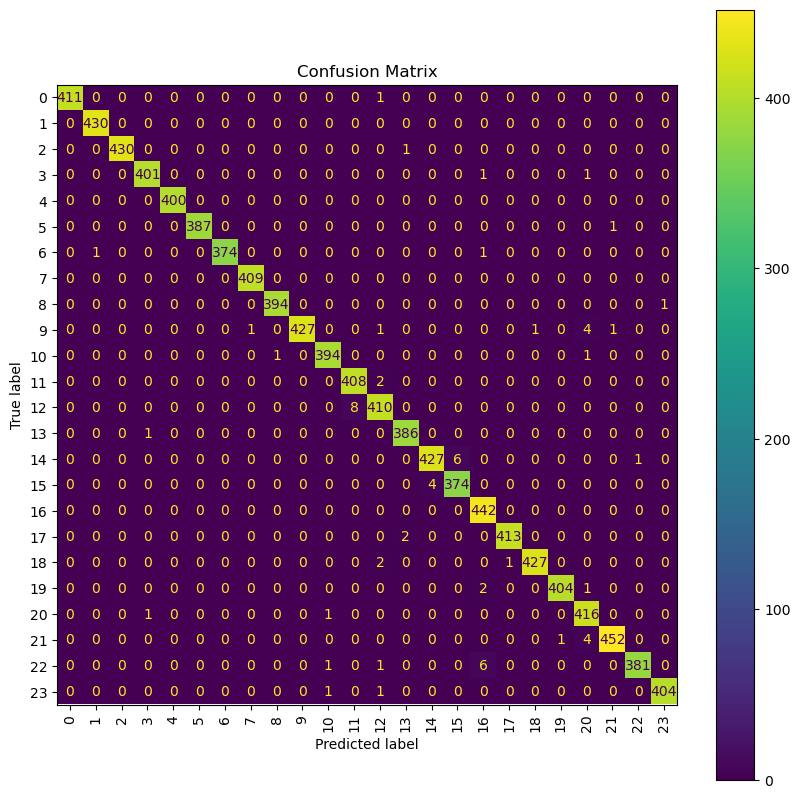

In [9]:
# Generate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
cmd = ConfusionMatrixDisplay(cm, display_labels=[i for i in range(num_classes)])
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the size
cmd.plot(ax=ax, xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

In [15]:
# Generate classification report
report = classification_report(all_labels, all_predictions, target_names=[f'Class {i}' for i in range(num_classes)], output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Print the classification report as a table
print(df_report)

# Save the classification report to a CSV file
df_report.to_csv('classification_report.csv', index=True)

              precision    recall  f1-score      support
Class 0        1.000000  0.997573  0.998785   412.000000
Class 1        0.997680  1.000000  0.998839   430.000000
Class 2        1.000000  0.997680  0.998839   431.000000
Class 3        0.995037  0.995037  0.995037   403.000000
Class 4        1.000000  1.000000  1.000000   400.000000
Class 5        1.000000  0.997423  0.998710   388.000000
Class 6        1.000000  0.994681  0.997333   376.000000
Class 7        0.997561  1.000000  0.998779   409.000000
Class 8        0.997468  0.997468  0.997468   395.000000
Class 9        1.000000  0.981609  0.990719   435.000000
Class 10       0.992443  0.994949  0.993695   396.000000
Class 11       0.980769  0.995122  0.987893   410.000000
Class 12       0.980861  0.980861  0.980861   418.000000
Class 13       0.992288  0.997416  0.994845   387.000000
Class 14       0.990719  0.983871  0.987283   434.000000
Class 15       0.984211  0.989418  0.986807   378.000000
Class 16       0.977876  1.0000